# Project Vetor II - UEL - Hypothetical flight


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

from rocketpy import Environment, Flight, Function, Rocket, SolidMotor

In [5]:
plt.style.use("seaborn-v0_8-dark-palette")

## RocketPy Simulation


### Environment


Defines the `Environment` object. 
Location: Londrina, Brazil.

In [6]:
# Environment conditions
env = Environment(
    gravity=9.81,
    latitude = -23.245282518586297, 
    longitude = -51.232450098784994,
    date=(2024, 12, 1, 13),
    timezone="America/Sao_Paulo",
    elevation=580,
)

env.max_expected_height = 2000

Visualize the `Environment` object



Gravity Details

Acceleration of gravity at surface level:    9.8100 m/s²
Acceleration of gravity at   2.000 km (ASL): 9.8100 m/s²


Launch Site Details

Launch Date: 2024-12-01 16:00:00 UTC | 2024-12-01 13:00:00 America/Sao_Paulo
Launch Site Latitude: -23.24528°
Launch Site Longitude: -51.23245°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 476221.37 W    7429308.07 S
Launch Site UTM zone: 22K
Launch Site Surface Elevation: 580.0 m


Atmospheric Model Details

Atmospheric Model Type: standard_atmosphere
standard_atmosphere Maximum Height: 2.000 km

Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 0.00°
Surface Wind Heading: 0.00°
Surface Pressure: 945.70 hPa
Surface Temperature: 284.39 K
Surface Air Density: 1.158 kg/m³
Surface Speed of Sound: 337.91 m/s


Earth Model Details

Earth Radius at Launch site: 6374.83 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034


Atmospheric Model Plots



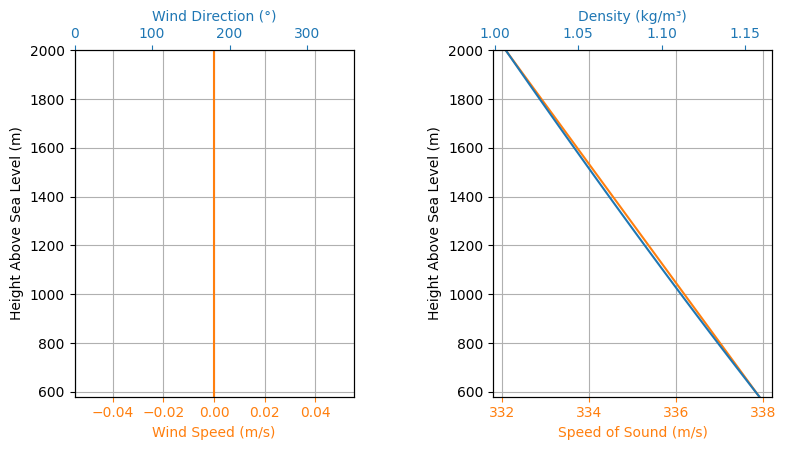

In [11]:
env.info()

### Motor


Define the `SolidMotor` object


In [ ]:
m300 = SolidMotor(
    thrust_source="../../data/motors/vetor-ii/vetor_ii_thrust_curve.csv",
    burn_time=1.8,
    dry_mass=0.4938,
    dry_inertia=(0, 0, 0),
    center_of_dry_mass_position=0.160/2,
    grains_center_of_mass_position=0.160/2,
    grain_number=1,
    grain_separation=0,
    grain_density= 1730,
    grain_outer_radius=0.044/2,
    grain_initial_inner_radius=0.00725/2,
    grain_initial_height=0.125,
    nozzle_radius=0.020/2,
    throat_radius=0.010/2,
    
)

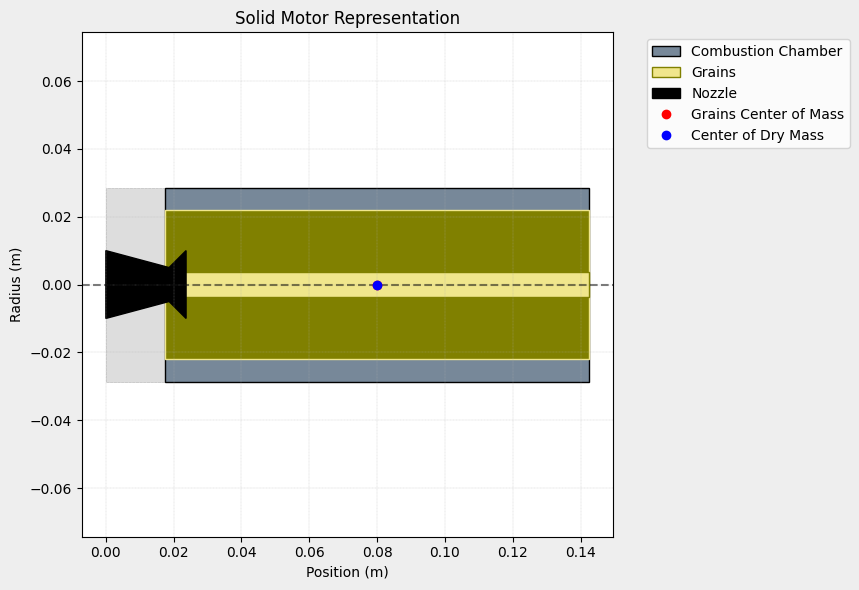

In [10]:
m300.plots.draw()

Nozzle Details
Nozzle Radius: 0.04445 m
Nozzle Throat Radius: 0.0214376 m

Grain Details
Number of Grains: 1
Grain Spacing: 0 m
Grain Density: 782.4 kg/m3
Grain Outer Radius: 0.042799 m
Grain Inner Radius: 0.033146999999999996 m
Grain Height: 0.1524 m
Grain Volume: 0.000 m3
Grain Mass: 0.275 kg

Motor Details
Total Burning Time: 1.8 s
Total Propellant Mass: 0.275 kg
Structural Mass Ratio: 0.004
Average Propellant Exhaust Velocity: 1013.523 m/s
Average Thrust: 154.613 N
Maximum Thrust: 272.733 N at 0.25 s after ignition.
Total Impulse: 278.304 Ns



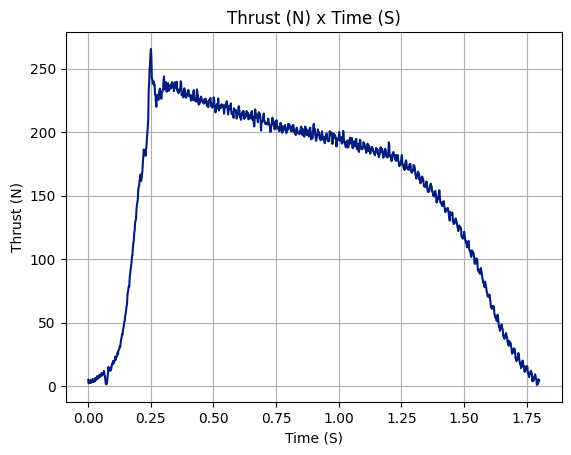

In [18]:
m300.info()

### Rocket


Create the `Rocket` object


In [25]:
vetor_ii = Rocket(
    radius=0.065/2,
    mass=1.079,
    inertia=(
        0.1163,
        0.1163,
        0.0005,
    ),
    power_off_drag=0.43,
    power_on_drag=0.43,
    center_of_mass_without_motor=0,
)
vetor_ii.add_motor(motor=m300, position=-0.600)

Adding nose cone

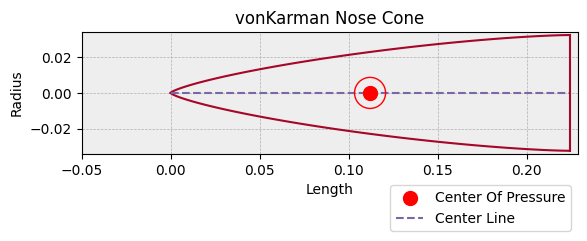

In [26]:
nose_cone = vetor_ii.add_nose(
    length=0.224,
    kind="vonKarman",
    position=0.314,
).draw()

Adding trapezoidal fins

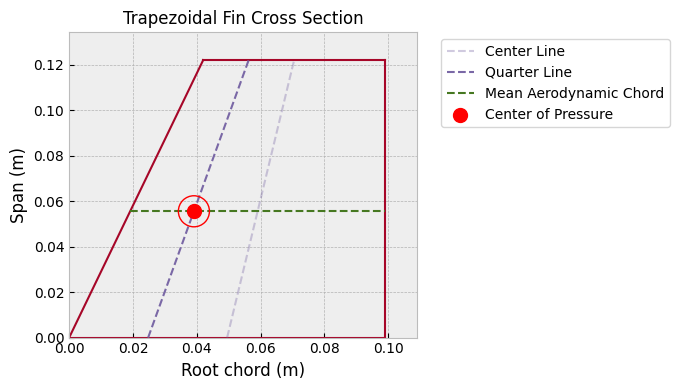

In [27]:
fin_set = vetor_ii.add_trapezoidal_fins(
    4,
    span=0.122,
    root_chord=0.099,
    tip_chord=0.057,
    position=-0.497,
).draw()

In [28]:
vetor_ii.info()


Inertia Details

Rocket Mass: 1.079 kg (without motor)
Rocket Dry Mass: 1.573 kg (with unloaded motor)
Rocket Loaded Mass: 1.893 kg
Rocket Structural Mass Ratio: 0.831
Rocket Inertia (with unloaded motor) 11: 0.208 kg*m2
Rocket Inertia (with unloaded motor) 22: 0.208 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.001 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.0325 m
Rocket Frontal Area: 0.003318 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.163 m
Rocket Center of Dry Mass - Nozzle Exit: 0.437 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.357 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.060 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 23.722/rad

Center of Pressure

Nose 

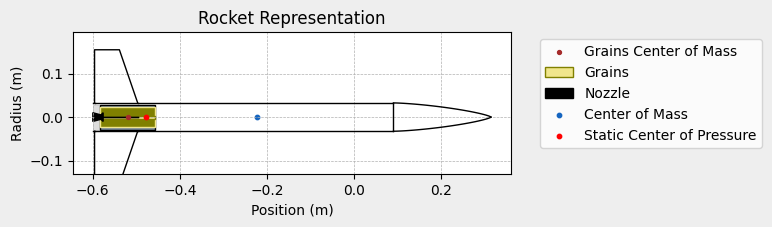

In [29]:
vetor_ii.draw()

### Flight


In [ ]:
# Flight
test_flight = Flight(
    rocket=bella_lui,
    environment=env,
    rail_length=parameters.get("rail_length")[0],
    inclination=parameters.get("inclination")[0],
)


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 407.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 1.000 | e1: -0.006 | e2: 0.006 | e3: 0.000
Euler Angles - Spin φ : 45.00° | Nutation θ: -1.00° | Precession ψ: -45.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 2.777 c


Surface Wind Conditions

Frontal Surface Wind Speed: 1.23 m/s
Lateral Surface Wind Speed: 0.26 m/s


Launch Rail

Launch Rail Length: 4.2 m
Launch Rail Inclination: 89.00°
Launch Rail Heading: 45.00°


Rail Departure State

Rail Departure Time: 0.359 s
Rail Departure Velocity: 16.184 m/s
Rail Departure Stability Margin: 2.818 c
Rail Departure Angle of Attack: 4.457°
Rail Departure Thrust-Weight Ratio: 5.416
Rail Departure Reynolds Number: 1.691e+05


Burn out State

Burn out time: 2.430 s
Altitude at burn out: 529.975 m (ASL) | 122.975 m (AGL)
Rocket speed at burn out: 85.171 m/s
Freestream veloci

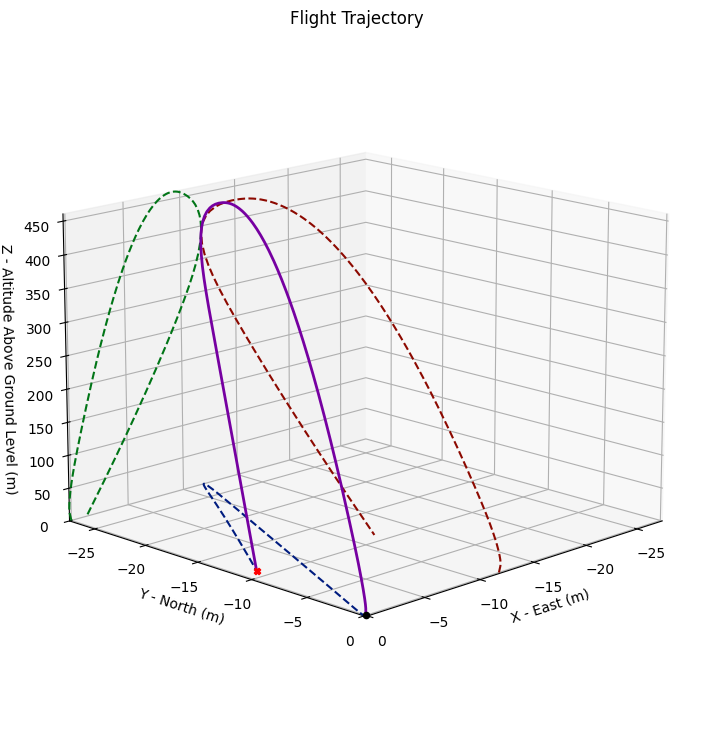

In [49]:
test_flight.info()
test_flight.plots.trajectory_3d()

## Comparison with the real flight data


Load the available flight data: altitude above ground level (m), vertical velocity (m/s), time (s)


In [50]:
flight_data = np.loadtxt(
    "../../data/rockets/EPFL_Bella_Lui/bella_lui_flight_data_filtered.csv",
    skiprows=1,
    delimiter=",",
    usecols=(2, 3, 4),
)

Convert to Function objects


In [51]:
actual_z = Function(
    source=np.column_stack((flight_data[:573, 0], flight_data[:573, 1])),
    inputs="Time (s)",
    outputs="Altitude above ground level (m)",
    interpolation="linear",
    extrapolation="zero",
)

actual_vz = Function(
    source=np.column_stack((flight_data[:573, 0], flight_data[:573, 2])),
    inputs="Time (s)",
    outputs="Vertical velocity (m/s)",
    interpolation="linear",
    extrapolation="zero",
)

# the actual acceleration will be calculated as the derivative of the actual velocity
actual_az = actual_vz.derivative_function()

We may need to filter the acceleration data to reduce the noise


In [52]:
az_filtered = savgol_filter(x=actual_az.source[:, 1], window_length=51, polyorder=3)

actual_az_filtered = Function(
    source=np.column_stack((actual_az.source[:, 0], az_filtered)),
    inputs="Time (s)",
    outputs="Vertical acceleration (m/s^2)",
    interpolation="linear",
    extrapolation="zero",
)

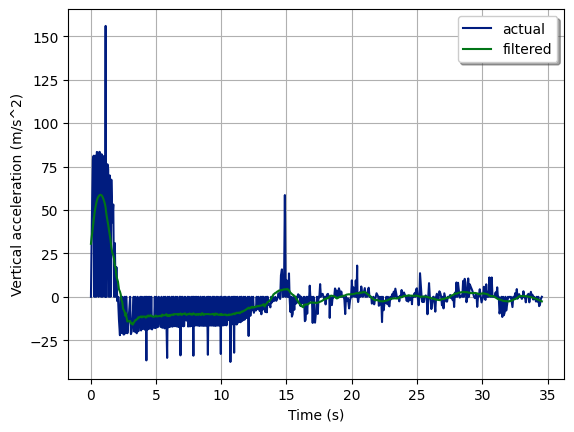

In [53]:
Function.compare_plots(
    [(actual_az, "actual"), (actual_az_filtered, "filtered")],
    xlabel="Time (s)",
    ylabel="Vertical acceleration (m/s^2)",
)

Get the simulated results


In [54]:
simulated_z = test_flight.z - env.elevation
simulated_vz = test_flight.vz
simulated_az = test_flight.az
simulated_t_final = test_flight.t_final
simulated_apogee = test_flight.apogee - env.elevation

### Plots comparison


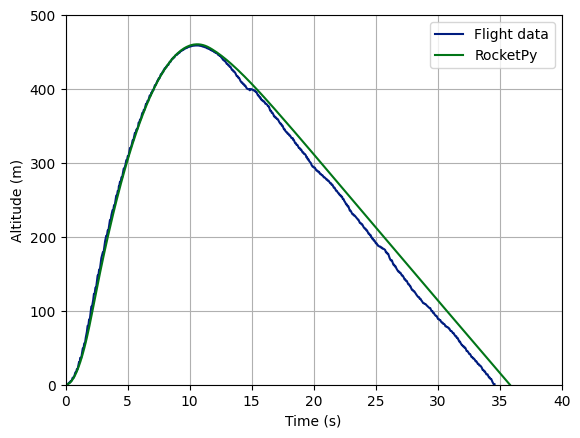

In [55]:
plt.plot(actual_z[:, 0], actual_z[:, 1], label="Flight data")
plt.plot(simulated_z[:, 0], simulated_z[:, 1], label="RocketPy")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.ylim(0, round(simulated_apogee, -2))
plt.xlim(0, round(simulated_t_final, -1))
plt.legend()
plt.grid()
plt.show()

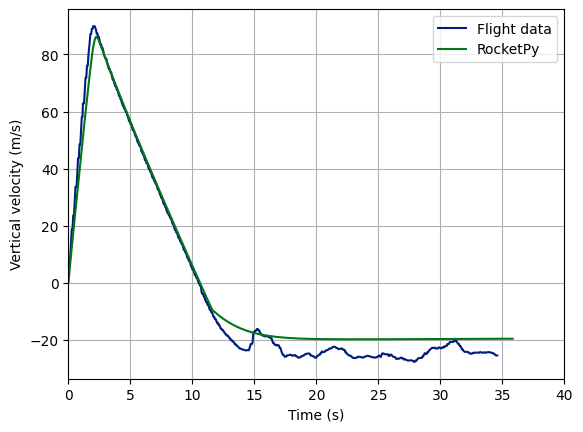

In [56]:
plt.plot(actual_vz[:, 0], actual_vz[:, 1], label="Flight data")
plt.plot(simulated_vz[:, 0], simulated_vz[:, 1], label="RocketPy")
plt.xlabel("Time (s)")
plt.ylabel("Vertical velocity (m/s)")
# plt.ylim()
plt.xlim(0, round(simulated_t_final, -1))
plt.legend()
plt.grid()
plt.show()

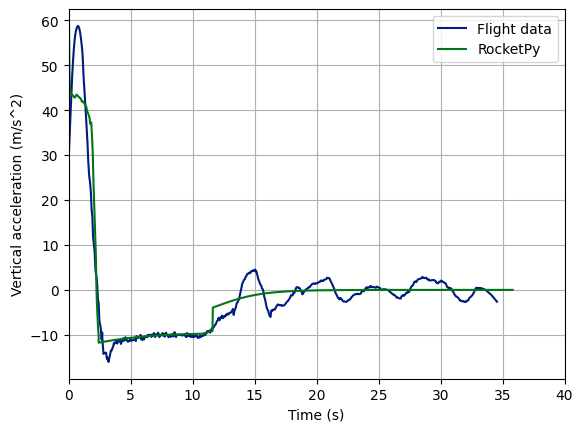

In [57]:
plt.plot(actual_az_filtered[:, 0], actual_az_filtered[:, 1], label="Flight data")
plt.plot(simulated_az[:, 0], simulated_az[:, 1], label="RocketPy")
plt.xlabel("Time (s)")
plt.ylabel("Vertical acceleration (m/s^2)")
# plt.ylim()
plt.xlim(0, round(simulated_t_final, -1))
plt.legend()
plt.grid()
plt.show()

### Numerical comparison


In [58]:
print("Apogee (AGL)")
print(f"RocketPy: {simulated_apogee:.2f} m")
print(f"Real data: {actual_z.max:.2f} m")
diff = abs(actual_z.max - simulated_apogee)
print(f"Absolute error: {diff:.2f} m")
print(f"Relative error: {diff / actual_z.max * 100:.2f} %")

Apogee (AGL)
RocketPy: 460.54 m
Real data: 458.97 m
Absolute error: 1.57 m
Relative error: 0.34 %


In [59]:
print("Max Velocity")
print(f"RocketPy:  {simulated_vz.max:.2f} m/s")
print(f"Real data: {actual_vz.max:.2f} m/s")
velocity_error = simulated_vz.max - actual_vz.max
print(f"Absolute error: {velocity_error:.2f} m/s")
relative_error = abs(velocity_error) / actual_vz.max * 100
print(f"Relative error: {relative_error:.2f} %")

Max Velocity
RocketPy:  86.17 m/s
Real data: 90.00 m/s
Absolute error: -3.83 m/s
Relative error: 4.25 %


In [60]:
print("Max Acceleration")
print(f"RocketPy:  {simulated_az.max:.2f} m/s²")
print(f"Real data (derivative): {actual_az_filtered.max:.2f} m/s²")
acceleration_error = simulated_az.max - actual_az_filtered.max
print(f"Absolute error: {acceleration_error:.2f} m/s^2")
relative_error = abs(acceleration_error) / actual_az_filtered.max * 100
print(f"Relative error: {relative_error:.2f} %")

Max Acceleration
RocketPy:  58.46 m/s²
Real data (derivative): 58.73 m/s²
Absolute error: -0.27 m/s^2
Relative error: 0.46 %
